In [1]:
using Gen
using Pkg
Pkg.activate("julia_by_example")
using Plots
using StatsPlots
using DelimitedFiles

  Activating project at `/gpfs/milgram/pi/yildirim/ilker/julia_by_example`


In [2]:
# helper function
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

In [3]:
@gen function change_point(N::Int=50)
    # year of change in regulations
    n ~ uniform_discrete(1, N)
    # intensity parameters before and after
    lambda1 ~ gamma(2, 1)
    lambda2 ~ gamma(2, 1)
    # draw a count for each year using its intensity param.
    for k=1:N
        {:data => k => :y} ~ poisson(k <= n ? lambda1 : lambda2)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], true, Union{Nothing, Some{Any}}[Some(50)], var"##change_point#292", Bool[0], false)

In [24]:
(trace, _) = Gen.generate(change_point, ())
get_choices(trace)

│
├── :lambda1 : 2.648441097660536
│
├── :n : 19
│
├── :lambda2 : 0.5942591773804239
│
└── :data
    │
    ├── 5
    │   │
    │   └── :y : 1
    │
    ├── 35
    │   │
    │   └── :y : 1
    │
    ├── 30
    │   │
    │   └── :y : 1
    │
    ├── 32
    │   │
    │   └── :y : 1
    │
    ├── 6
    │   │
    │   └── :y : 4
    │
    ├── 45
    │   │
    │   └── :y : 1
    │
    ├── 4
    │   │
    │   └── :y : 3
    │
    ├── 13
    │   │
    │   └── :y : 1
    │
    ├── 12
    │   │
    │   └── :y : 0
    │
    ├── 28
    │   │
    │   └── :y : 0
    │
    ├── 23
    │   │
    │   └── :y : 0
    │
    ├── 41
    │   │
    │   └── :y : 0
    │
    ├── 43
    │   │
    │   └── :y : 0
    │
    ├── 11
    │   │
    │   └── :y : 2
    │
    ├── 36
    │   │
    │   └── :y : 0
    │
    ├── 39
    │   │
    │   └── :y : 0
    │
    ├── 7
    │   │
    │   └── :y : 2
    │
    ├── 25
    │   │
    │   └── :y : 2
    │
    ├── 34
    │   │
    │   └── :y : 1
    │
    ├── 50
    │   │
    │ 

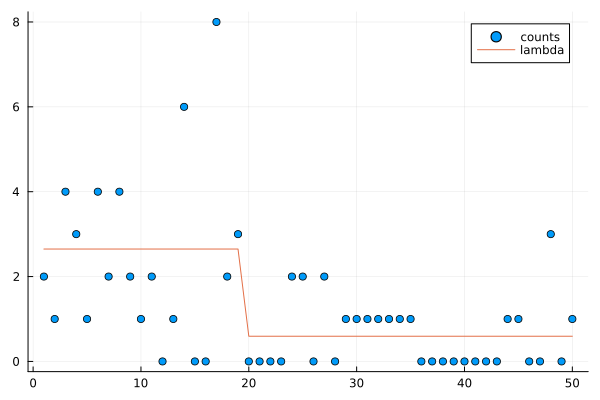

In [26]:
N=50
x = range(1, N, length=N)
y1 = [trace[:data => k => :y] for k=1:N]
y2 = [repeat([trace[:lambda1]], (trace[:n]));  repeat([trace[:lambda2]], (50-trace[:n]))]

plot(x, y1, label="counts", seriestype=:scatter)
plot!(x, y2, label="lambda")

In [30]:
#writedlm("count_data.txt", y1)

In [31]:
# helper function to create a choicemap with the observed data xs
function make_constraints(xs::Vector{})
    # choicemap to encode observations
    constraints = Gen.choicemap()
    # fill in the choicemap with the observed draws
    for i=1:length(xs)
        constraints[:data => i => :y] = xs[i]
    end
    # return the observations
    constraints
end
observations = make_constraints(y1)

│
└── :data
    │
    ├── 5
    │   │
    │   └── :y : 1
    │
    ├── 35
    │   │
    │   └── :y : 1
    │
    ├── 30
    │   │
    │   └── :y : 1
    │
    ├── 32
    │   │
    │   └── :y : 1
    │
    ├── 6
    │   │
    │   └── :y : 4
    │
    ├── 45
    │   │
    │   └── :y : 1
    │
    ├── 4
    │   │
    │   └── :y : 3
    │
    ├── 13
    │   │
    │   └── :y : 1
    │
    ├── 12
    │   │
    │   └── :y : 0
    │
    ├── 28
    │   │
    │   └── :y : 0
    │
    ├── 23
    │   │
    │   └── :y : 0
    │
    ├── 41
    │   │
    │   └── :y : 0
    │
    ├── 43
    │   │
    │   └── :y : 0
    │
    ├── 11
    │   │
    │   └── :y : 2
    │
    ├── 36
    │   │
    │   └── :y : 0
    │
    ├── 39
    │   │
    │   └── :y : 0
    │
    ├── 7
    │   │
    │   └── :y : 2
    │
    ├── 25
    │   │
    │   └── :y : 2
    │
    ├── 34
    │   │
    │   └── :y : 1
    │
    ├── 50
    │   │
    │   └── :y : 1
    │
    ├── 2
    │   │
    │   └── :y : 1
    │
    ├── 10
    │   │


In [32]:
# do inference
function block_resimulation_update(tr)
    # update the lambda parameters
    lambda_params = select(:lambda1, :lambda2)
    (tr, _) = mh(tr, lambda_params)

    # update change point, n
    cp = select(:n)
    (tr, _) = mh(tr, cp)

    # return the updated trace
    tr
end

block_resimulation_update (generic function with 1 method)

In [33]:
function block_resimulation_inference(observations)
    (tr, _) = generate(change_point, (), observations)
    for iter=1:500
        tr=block_resimulation_update(tr)
    end
    tr
end 

block_resimulation_inference (generic function with 1 method)

In [34]:
scores = Vector{Float64}(undef, 10)
inferred_lambda = zeros(Float64, 10, 2)
inferred_n = Vector{Int}(undef, 10)
for i=1:10
    @time tr = block_resimulation_inference(observations)
    scores[i] = get_score(tr)
    inferred_lambda[i,:] = [tr[:lambda1], tr[:lambda2]]
    inferred_n[i] = tr[:n]
end
println("Log probability: ", logmeanexp(scores))

  0.348817 seconds (1.62 M allocations: 124.475 MiB, 17.13% gc time, 12.68% compilation time)
  0.201284 seconds (1.59 M allocations: 122.823 MiB, 11.05% gc time)
  0.180238 seconds (1.59 M allocations: 122.823 MiB, 15.82% gc time)
  0.179477 seconds (1.59 M allocations: 122.823 MiB, 15.79% gc time)
  0.179625 seconds (1.59 M allocations: 122.823 MiB, 15.82% gc time)
  0.179885 seconds (1.59 M allocations: 122.823 MiB, 15.71% gc time)
  0.171611 seconds (1.59 M allocations: 122.823 MiB, 11.05% gc time)
  0.178241 seconds (1.59 M allocations: 122.823 MiB, 15.92% gc time)
  0.177994 seconds (1.59 M allocations: 122.823 MiB, 15.87% gc time)
  0.178371 seconds (1.59 M allocations: 122.823 MiB, 15.82% gc time)
Log probability: -78.86537977029685


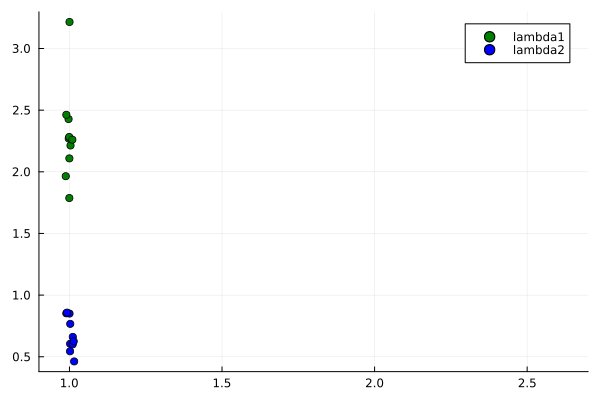

In [35]:
plot(repeat([1], 10) + 0.01*randn(10), inferred_lambda[:,1],  seriestype=:scatter, label="lambda1", color="green")
plot!(repeat([1], 10) + 0.01*randn(10), inferred_lambda[:,2], seriestype=:scatter, label="lambda2", color="blue")
xlims!(0.9, 2.7)

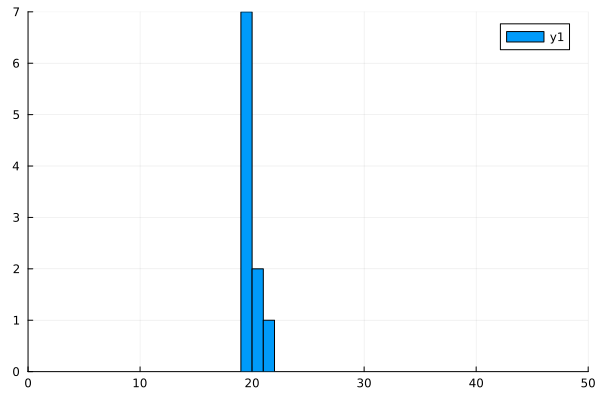

In [36]:
plot(inferred_n, seriestype=:histogram)
xlims!((0, N))

In [37]:
function visualize_trace(trace; title)
    N = 50
    x = range(1, N, length=N)
    y1 = [trace[:data => k => :y] for k=1:N]
    y2 = [repeat([trace[:lambda1]], (trace[:n]));  repeat([trace[:lambda2]], (50-trace[:n]))]

    plot(x, y1, label="counts", seriestype=:scatter, title=title)
    plot!(x, y2, label="lambda")
end

visualize_trace (generic function with 1 method)

[ Info: Saved animation to /gpfs/milgram/pi/yildirim/ilker/tmp.gif


Plots.AnimatedGif("/gpfs/milgram/pi/yildirim/ilker/tmp.gif")
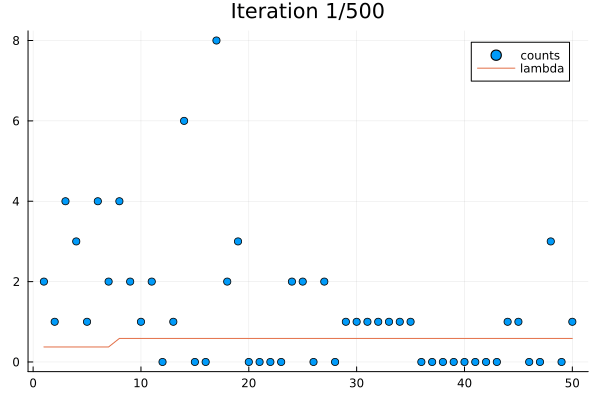

In [38]:
t, = generate(change_point, (), observations)

viz = Plots.@animate for i in 1:500
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/500")
end;
gif(viz)

In [39]:
@gen function intensity_proposal(current_trace)
    lambda1 ~ uniform(max(current_trace[:lambda1] - 0.5, 0), current_trace[:lambda1] + 0.5)
    lambda2 ~ uniform(max(current_trace[:lambda2] - 0.5, 0), current_trace[:lambda2] + 0.5)
end;

In [40]:
function random_walk_mh(tr)
    # make a random-walk update on lambdas
    (tr, _) = mh(tr, intensity_proposal, ())

    # block resimulation for the change point index
    # update change point, n
    cp = select(:n)
    (tr, _) = mh(tr, cp)

    # return the updated trace
    tr
end

random_walk_mh (generic function with 1 method)

[ Info: Saved animation to /gpfs/milgram/pi/yildirim/ilker/tmp.gif


Plots.AnimatedGif("/gpfs/milgram/pi/yildirim/ilker/tmp.gif")
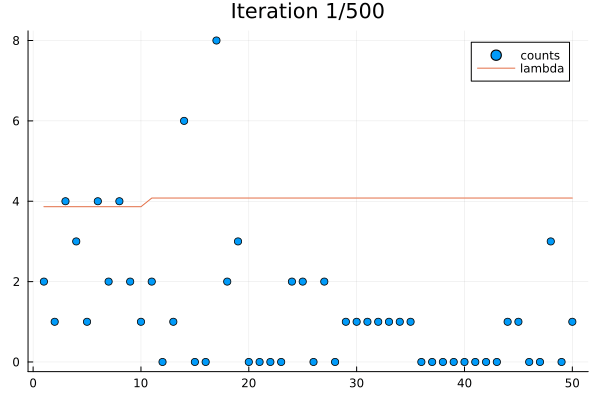

In [41]:
t, = generate(change_point, (), observations)

viz = Plots.@animate for i in 1:500
    global t
    t = random_walk_mh(t)
    visualize_trace(t; title="Iteration $i/500")
end;
gif(viz)

In [42]:
scores = Vector{Float64}(undef, 10)
inferred_lambda = zeros(Float64, 10, 2)
inferred_n = Vector{Int}(undef, 10)
for i=1:10
    (tr, _) = generate(change_point, (), observations)
    for k in 1:500
        tr = random_walk_mh(tr)
    end
    scores[i] = get_score(tr)
    inferred_lambda[i,:] = [tr[:lambda1], tr[:lambda2]]
    inferred_n[i] = tr[:n]
end
println("Log probability: ", logmeanexp(scores))

Log probability: -78.4355091074917


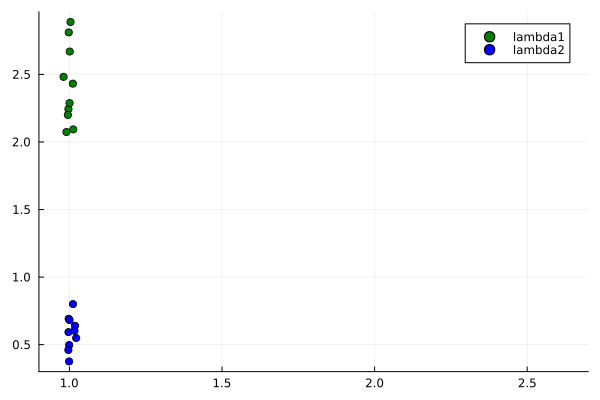

In [43]:
plot(repeat([1], 10) + 0.01*randn(10), inferred_lambda[:,1],  seriestype=:scatter, label="lambda1", color="green")
plot!(repeat([1], 10) + 0.01*randn(10), inferred_lambda[:,2], seriestype=:scatter, label="lambda2", color="blue")
xlims!(0.9, 2.7)

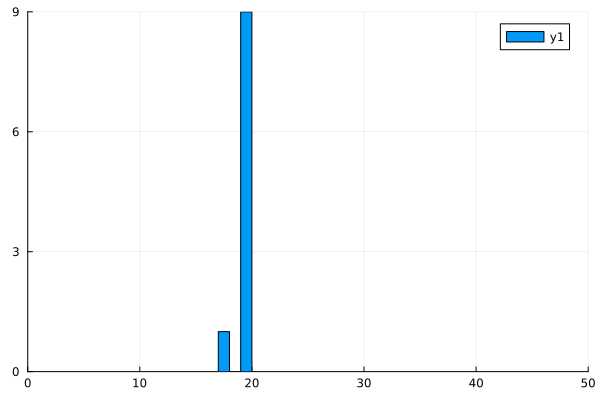

In [44]:
plot(inferred_n, seriestype=:histogram)
xlims!((0, N))